<a href="https://colab.research.google.com/github/Klop4ikk/3int/blob/main/train_light.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Загрузка данных

Импорт и установка библиотек

In [1]:
!pip install pmdarima
!pip install numpy==1.26.4
!pip install keras-tuner



import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense,GRU
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from xgboost import XGBRegressor
import warnings
import requests
import statsmodels
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from io import BytesIO
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer
from tensorflow.keras.models import Sequential
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.stattools import acf, adfuller
from sklearn.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from tensorflow.keras.layers import LSTM, Dense, Dropout
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.tsa.arima.model import ARIMA



warnings.filterwarnings("ignore")
%matplotlib inline

Выберите способ загрузки данных

In [2]:
url = "https://github.com/samoletpanfilov/reinforcement_task/raw/refs/heads/master/data/train.xlsx"  # Ссылка должна содержать raw
response = requests.get(url)
df_ts = pd.read_excel(BytesIO(response.content), engine='openpyxl')

df_ts = df_ts.sort_values(by='dt', ascending=True)

In [3]:
# df_ts = pd.read_excel('/content/drive/MyDrive/int/train.xlsx')

# Анализ и предобработка

### просмотр статистической информации

In [4]:
df_ts.head(15)

,dt,Цена на арматуру
0,2015-01-05,32900
1,2015-01-12,32500
2,2015-01-19,32000
3,2015-01-26,30700
4,2015-02-02,30300
5,2015-02-09,30300
6,2015-02-16,30100
7,2015-02-23,29400
8,2015-03-02,29200
9,2015-03-09,29000


In [5]:
df_ts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   dt                400 non-null    datetime64[ns]
 1   Цена на арматуру  400 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 6.4 KB


In [6]:
# Проверка на наличие NaN
df_ts['dt'].isna().sum()

0

In [7]:
df_ts.describe()

,dt,Цена на арматуру
count,400,400.000000
mean,2018-11-01 12:00:00,39229.475000
min,2015-01-05 00:00:00,21000.000000
25%,2016-12-03 06:00:00,31075.000000
50%,2018-11-01 12:00:00,35450.000000
75%,2020-09-29 18:00:00,42000.000000
max,2022-08-29 00:00:00,79000.000000
std,NaN,13407.979668


In [8]:
df_ts.shape

(400, 2)

### Визуализация

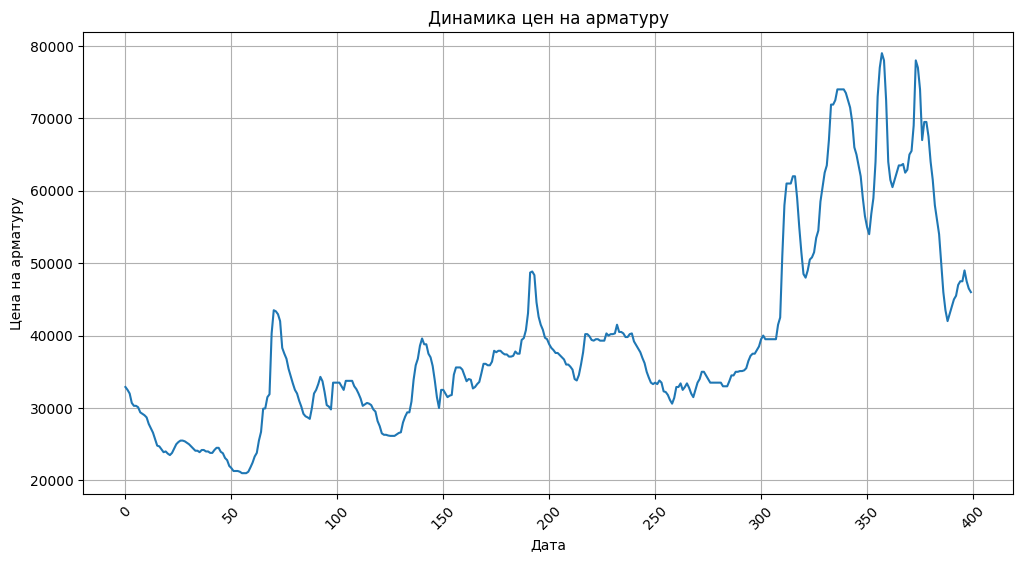

In [9]:
# Строим график
plt.figure(figsize=(12, 6))
plt.plot(df_ts["Цена на арматуру"], marker='', linestyle='-')

# Настроим оси и заголовок
plt.xlabel("Дата")
plt.ylabel("Цена на арматуру")
plt.title("Динамика цен на арматуру")
plt.grid(True)

# Улучшим читаемость меток дат
plt.xticks(rotation=45)

# Показываем график
plt.show()

**Вопросы к графику:**

 1.Есть ли тренд?

 2.Есть ли сезонность?

 3.Насколько сильный шум?



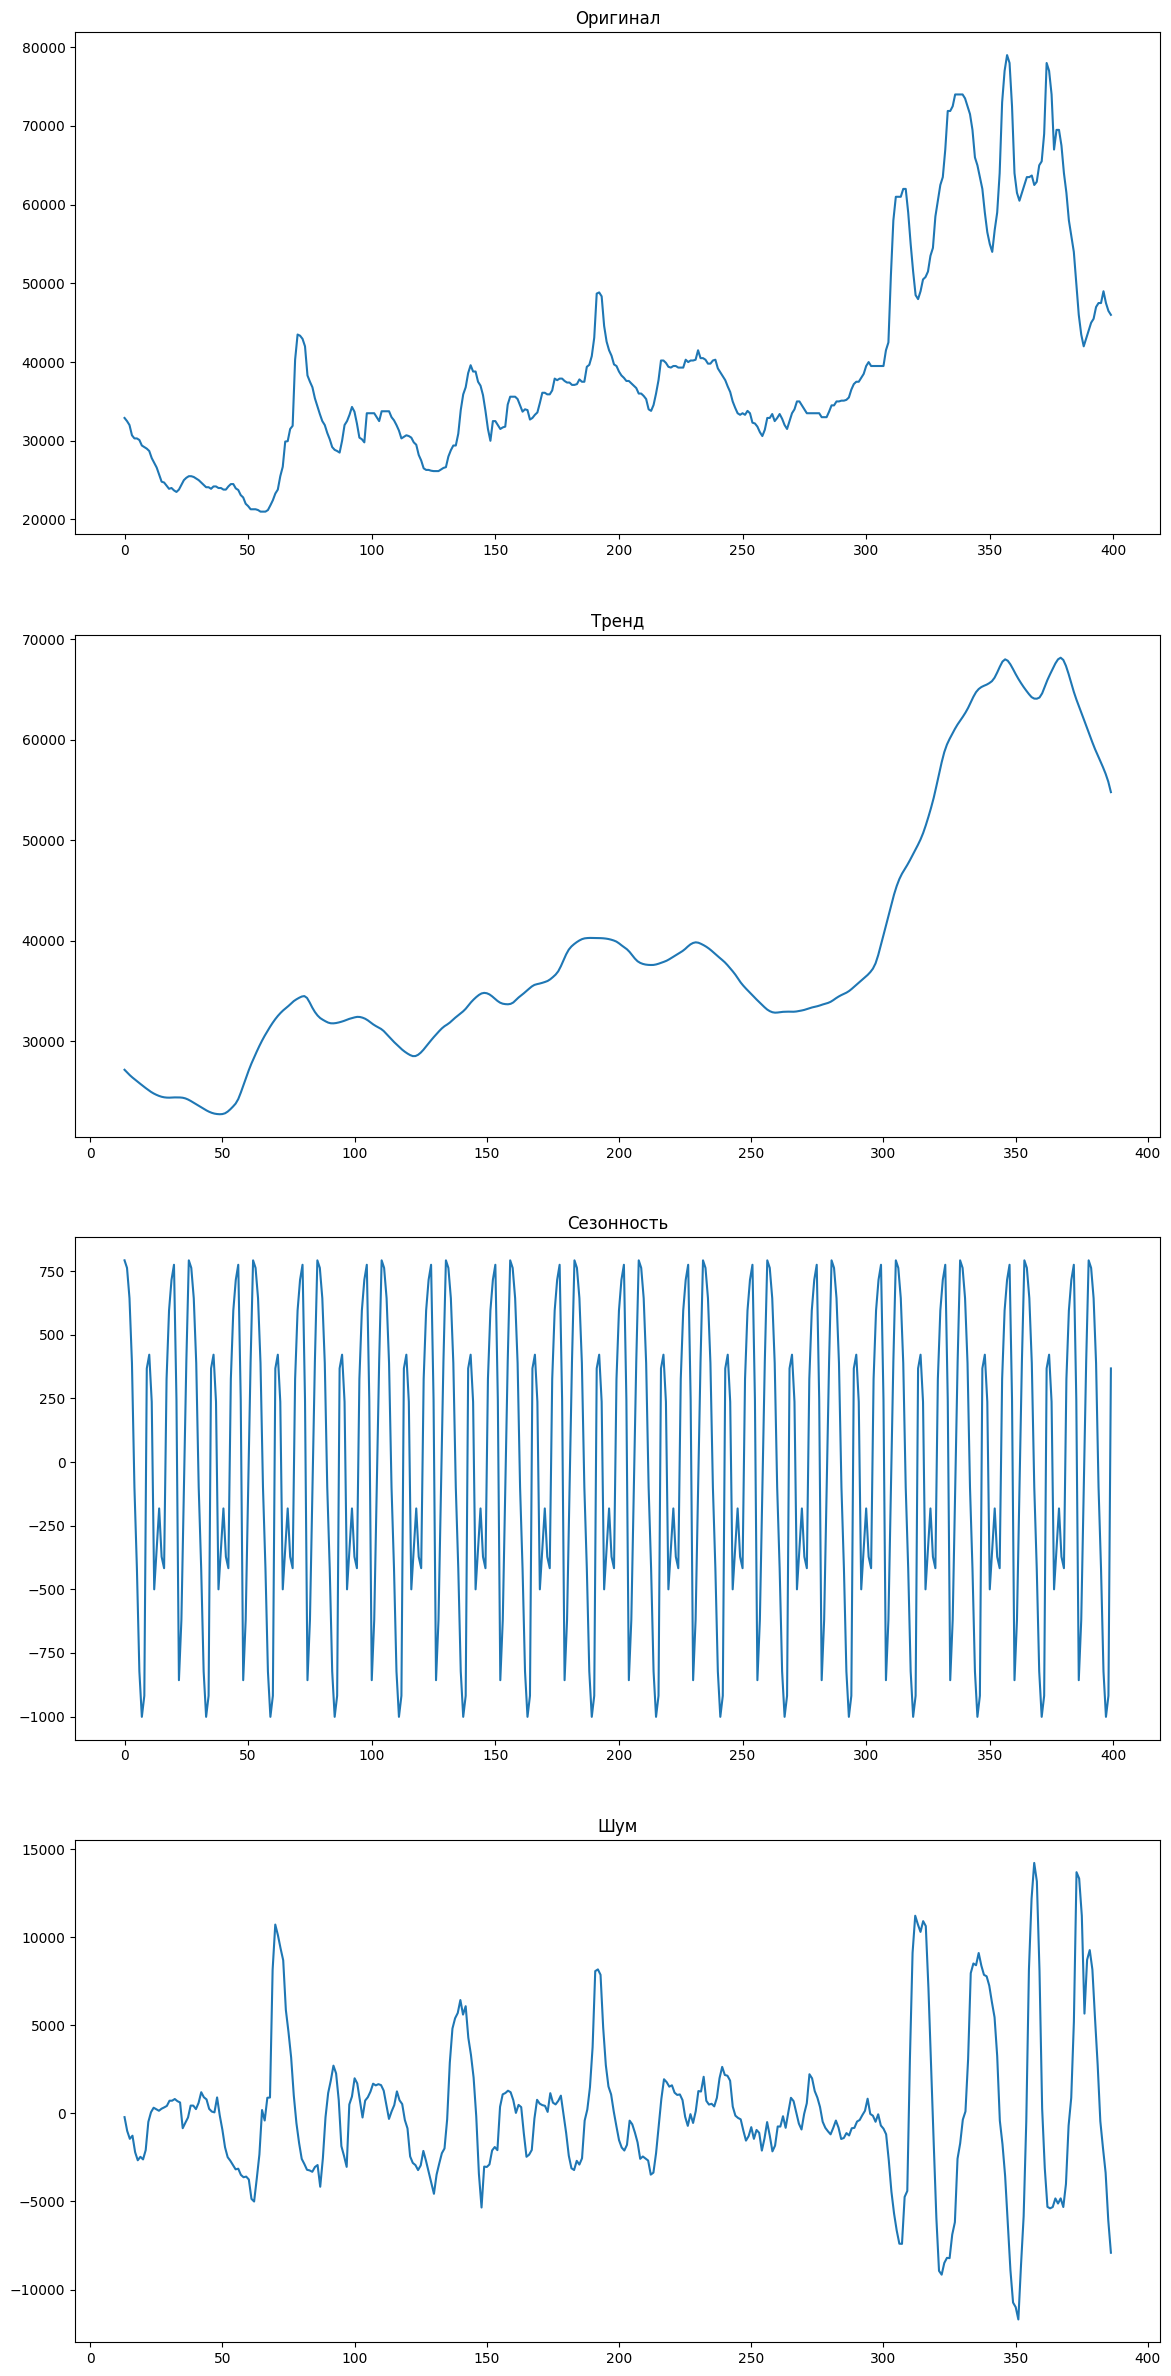

In [10]:
# Разложим ряд на компоненты и проверим ответы на вопросы

fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(14, 30))
decompose = seasonal_decompose(df_ts['Цена на арматуру'],period = 26)

ax[0].set_title('Оригинал')
ax[1].set_title('Тренд')
ax[2].set_title('Сезонность')
ax[3].set_title('Шум')

decompose.observed.plot(ax=ax[0])
decompose.trend.plot(ax=ax[1])
decompose.seasonal.plot(ax=ax[2])
decompose.resid.plot(ax=ax[3]);

Декомпозиция временного ряда


🔹 Оригинальный ряд  


Исходные данные, содержащие тренд, сезонность и шум.


 📈 Тренд

   
Общий восходящий тренд, отражающий долгосрочный рост.


🔄 Сезонность


Выраженные периодические колебания, сохраняющиеся на протяжении всего ряда.


 🔀 Шум  

Умеренный, но увеличивается ближе к концу ряда, что может указывать на аномалии или возрастание волатильности.


### Работа с автокорреляцией

In [11]:
# Получил 'сырые' значения автокорреляций
acf(df_ts["Цена на арматуру"] ,nlags = 100, fft = False)

array([1.        , 0.99138242, 0.97367714, 0.95122039, 0.92740427,
       0.90357365, 0.88126621, 0.8606089 , 0.84235253, 0.82671727,
       0.81349611, 0.8020525 , 0.7925797 , 0.78508849, 0.78019657,
       0.77692922, 0.77376814, 0.76901294, 0.76227632, 0.75319077,
       0.74261145, 0.7309889 , 0.71862345, 0.7046383 , 0.68939965,
       0.67325908, 0.65612584, 0.63820561, 0.62109396, 0.60459259,
       0.58872289, 0.57435372, 0.56120831, 0.54900152, 0.5377084 ,
       0.5271632 , 0.51674918, 0.5068141 , 0.49691253, 0.48636205,
       0.47460061, 0.4600824 , 0.44257206, 0.42285538, 0.40223733,
       0.38033844, 0.35769402, 0.33517203, 0.31316745, 0.29306128,
       0.27522925, 0.2595102 , 0.24447201, 0.23086215, 0.21896621,
       0.20859445, 0.1993889 , 0.19088593, 0.18300826, 0.1757314 ,
       0.16880023, 0.16166525, 0.15350675, 0.14370082, 0.13267574,
       0.12198755, 0.11231837, 0.10288107, 0.0929827 , 0.08286002,
       0.07336018, 0.06476539, 0.05709237, 0.05068118, 0.04473

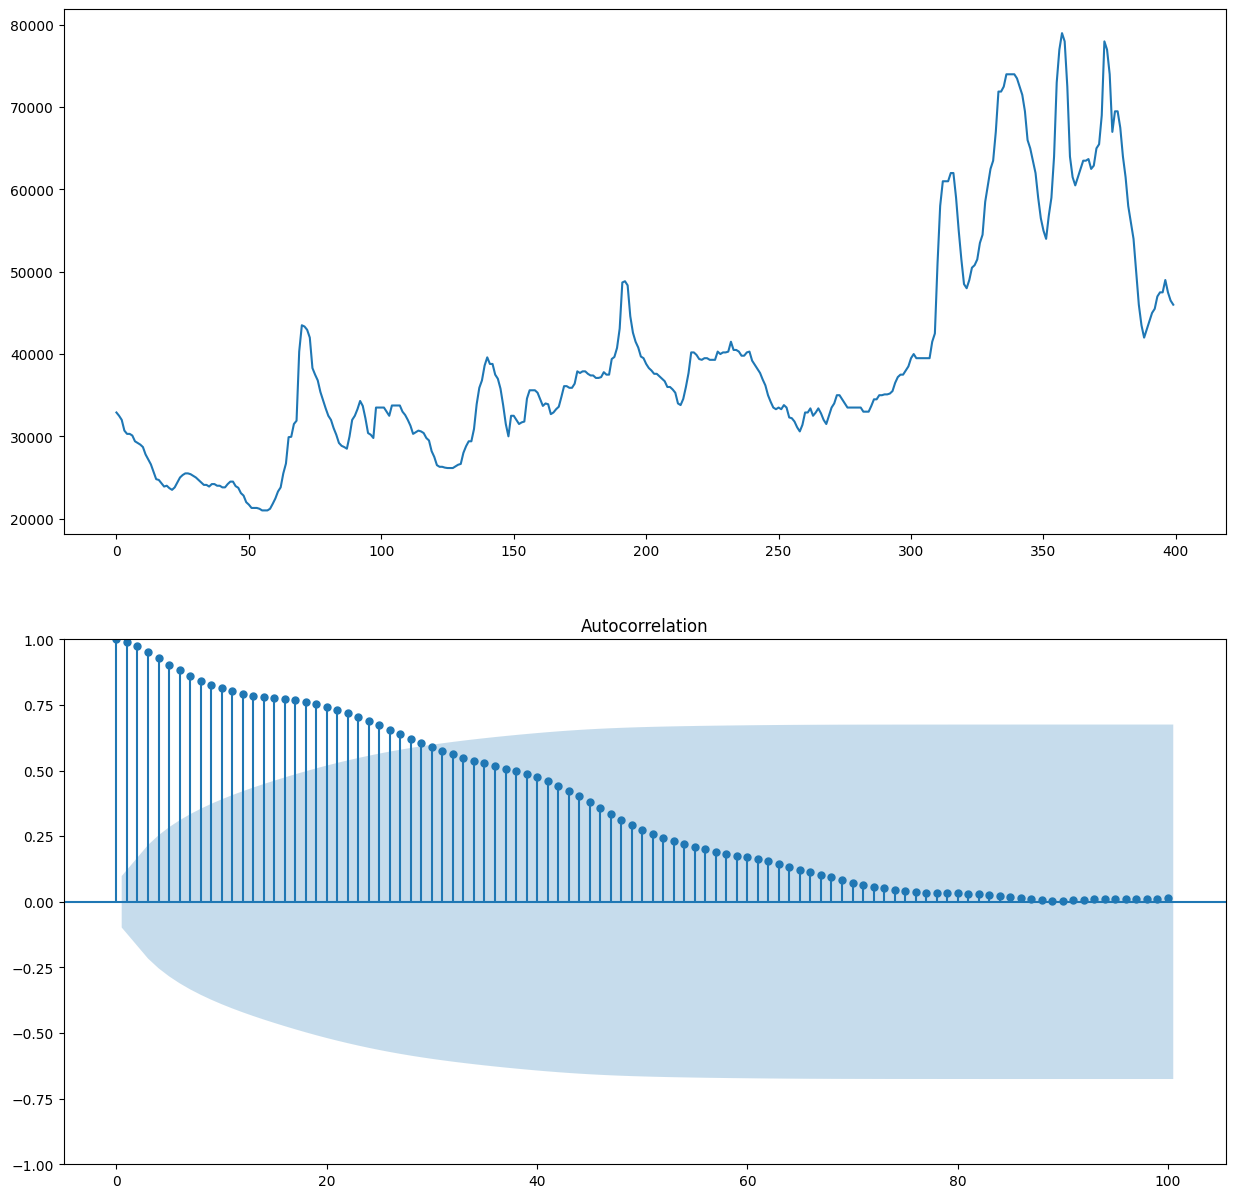

In [12]:
# Визуализация автокорреляции
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 15))
df_ts['Цена на арматуру'].plot(ax=ax[0])
plot_acf(df_ts['Цена на арматуру'], lags=100, ax=ax[1]);

Высокая корреляция на малых лагах указывает на сильную зависимость текущих значений от предыдущих.

Корреляция постепенно уменьшается с увеличением лага, что характерно для многих временных рядов.


Светло-синяя область – это доверительный интервал: значения внутри него можно считать статистически незначимыми.

In [13]:
# проверка на стационарность первоначального ряда
# Функция для выполнения теста ADF
def adf_test(series):
    result = adfuller(series)
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    print(f"Critical Values: {result[4]}")

    if result[1] < 0.05:
        print("Ряд стационарен (p-value < 0.05)")
    else:
        print("Ряд нестационарен (p-value >= 0.05)")
# Проверим на стационарность исходный ряд
adf_test(df_ts['Цена на арматуру'])

ADF Statistic: -1.9258699893713456
p-value: 0.31999061025699155
Critical Values: {'1%': -3.4470566389664703, '5%': -2.8689037160476016, '10%': -2.570692663557422}
Ряд нестационарен (p-value >= 0.05)


Text(0.5, 1.0, 'Распределение цен на арматуру')

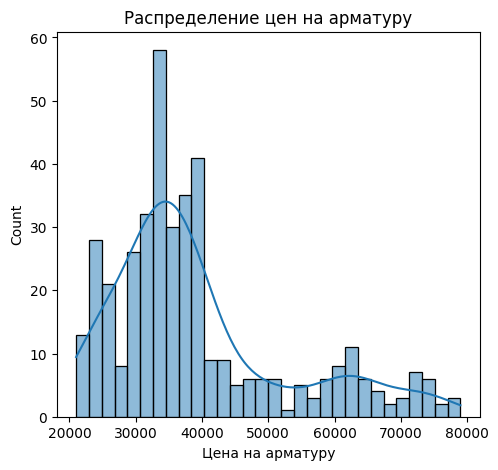

In [14]:
plt.figure(figsize=(12, 5))

# Гистограмма
plt.subplot(1, 2, 1)
sns.histplot(df_ts["Цена на арматуру"], bins=30, kde=True)
plt.title("Распределение цен на арматуру")


На графики видем что большинство значений  примерно сосредоточено между 30тыс и 40тыс

# Модели

Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 156ms/step - loss: 0.1771 - val_loss: 0.0719
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.0296 - val_loss: 0.1497
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.0206 - val_loss: 0.0756
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0164 - val_loss: 0.0568
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - loss: 0.0131 - val_loss: 0.0760
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - loss: 0.0115 - val_loss: 0.0444
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 158ms/step - loss: 0.0128 - val_loss: 0.0437
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 178ms/step - loss: 0.0106 - val_loss: 0.0465
Epoch 9/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0082 - val_loss: 0.0591
Epoch 10/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0108 - val_loss: 0.0429
Epoch 11/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - loss: 0.0116 - val_loss: 0.0442
Epoch 12/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss:

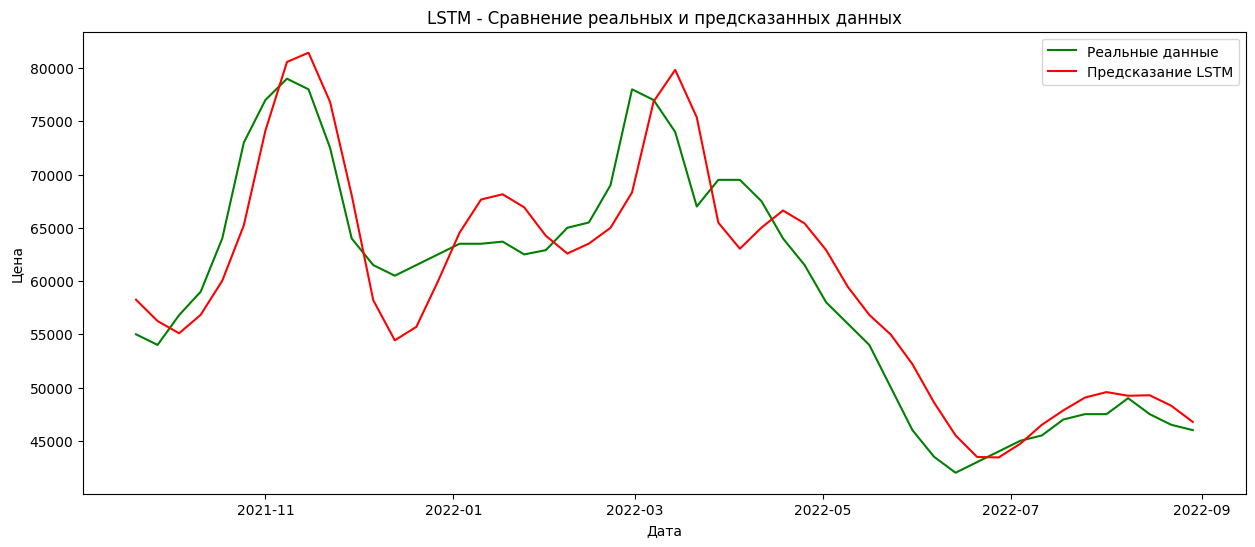

=== GRU ===
MAE: 2166.23
RMSE: 3128.88
R²: 0.9152



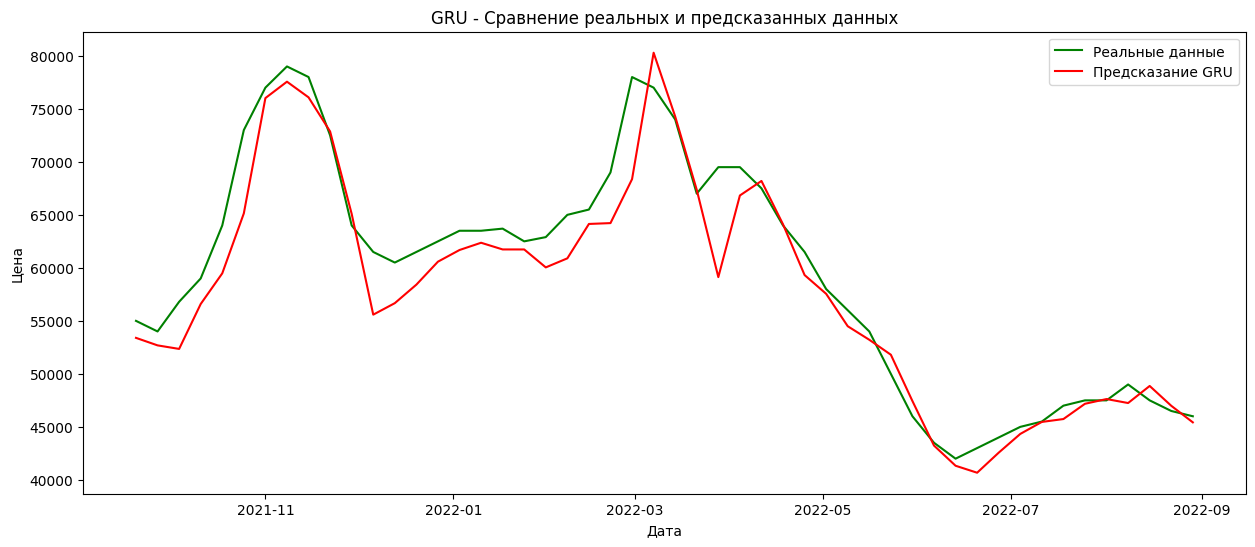

=== XGBoost ===
MAE: 10393.09
RMSE: 13081.78
R²: -0.4819



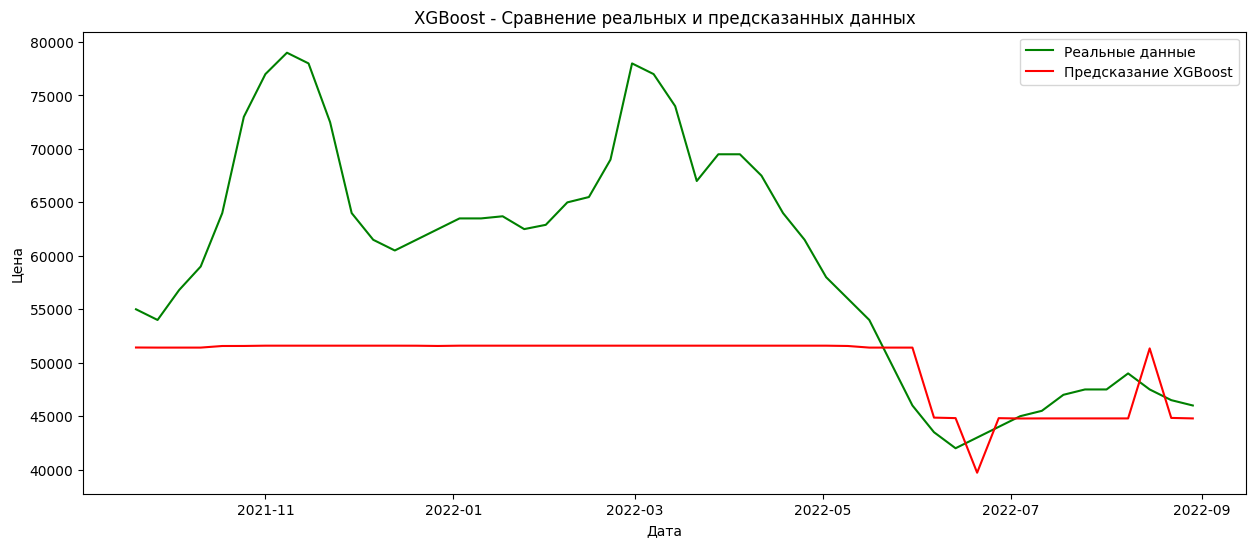

=== ARIMA ===
MAE: 18179.81
RMSE: 21029.39
R²: -2.8295



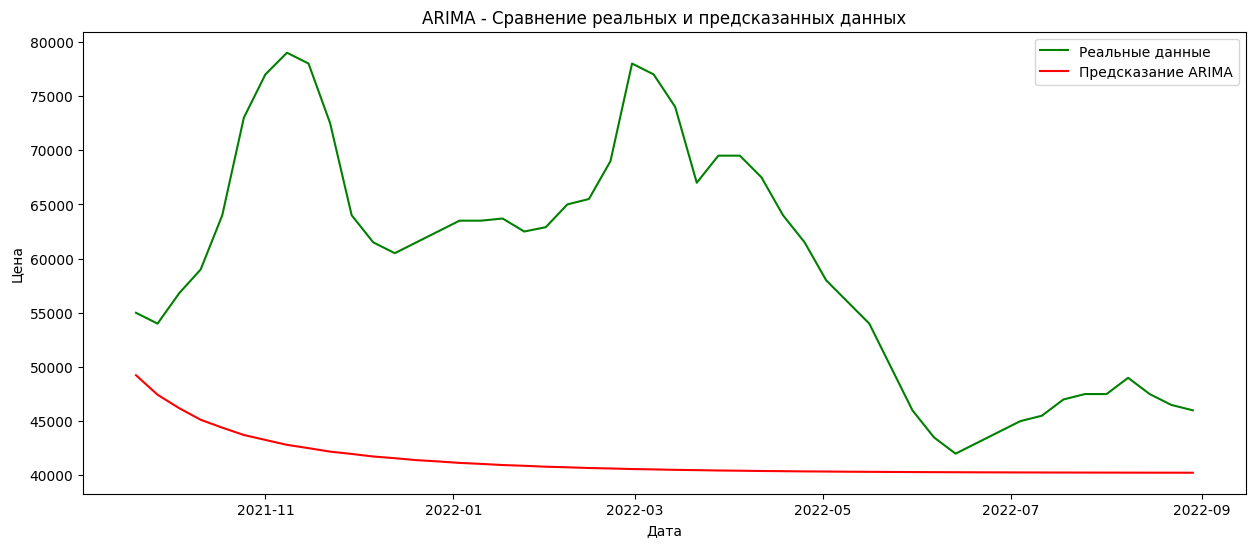


Лучшая модель: GRU
MAE: 2166.23
RMSE: 3128.88
R²: 0.9152


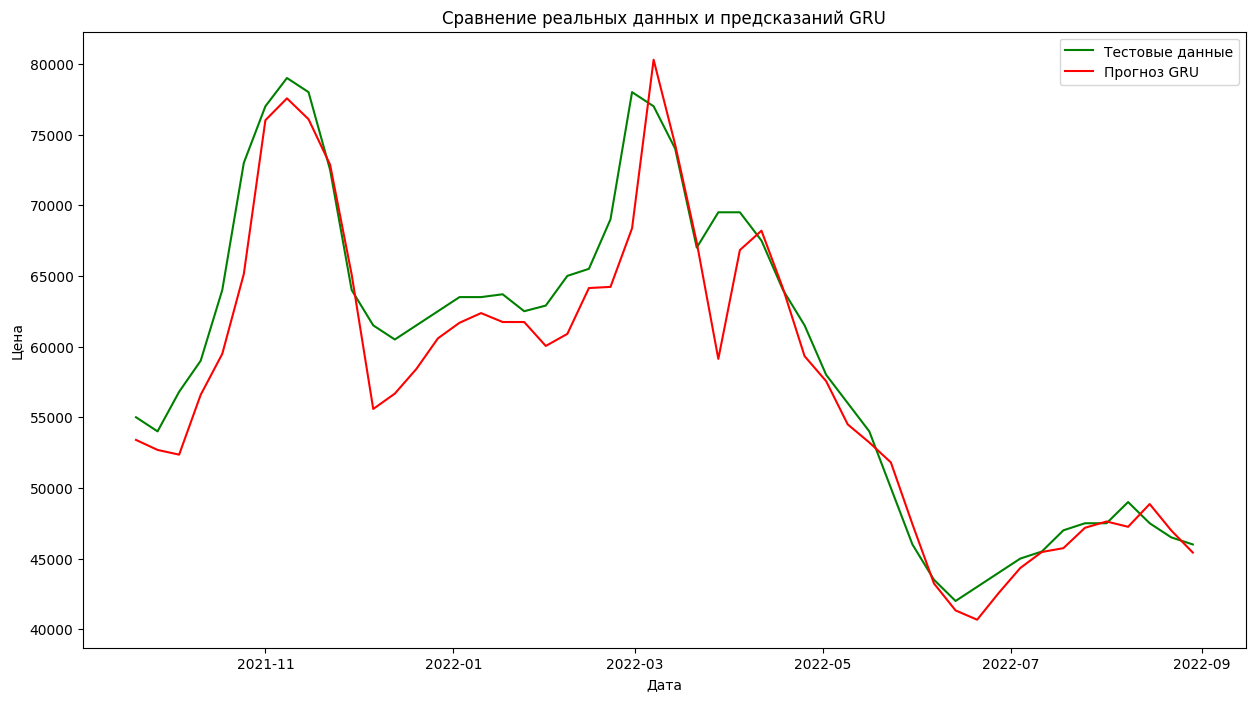

Предсказания сохранены в GRU_predictions.csv


In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense
from xgboost import XGBRegressor
from statsmodels.tsa.arima.model import ARIMA
import pickle
from joblib import dump
import warnings

# Игнорируем предупреждения для чистоты вывода
warnings.filterwarnings('ignore')

# Функция вычисления метрик и сохранения модели
def evaluate_model(y_true, y_pred, model_name, model_obj=None):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)

    print(f"=== {model_name} ===")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R²: {r2:.4f}\n")

    plt.figure(figsize=(15, 6))
    plt.plot(test_data.index[time_step:][:len(y_true)], y_true, label="Реальные данные", color="green")
    plt.plot(test_data.index[time_step:][:len(y_pred)], y_pred, label=f"Предсказание {model_name}", color="red")
    plt.title(f"{model_name} - Сравнение реальных и предсказанных данных")
    plt.xlabel("Дата")
    plt.ylabel("Цена")
    plt.legend()
    plt.show()

    # Сохраняем модель, если передана
    if model_obj is not None:
        if model_name in ["LSTM", "GRU"]:
            model_obj.save(f'{model_name}_model.h5')
        else:
            with open(f'{model_name}_model.pkl', 'wb') as f:
                pickle.dump(model_obj, f)

    return {'model': model_name, 'MAE': mae, 'RMSE': rmse, 'R²': r2, 'predictions': y_pred}

# Загрузка данных (предполагаем, что df_ts уже существует)
df_ts['dt'] = pd.to_datetime(df_ts['dt'])
df_ts.set_index('dt', inplace=True)

# Разделение данных
train_data, test_data = train_test_split(df_ts, test_size=0.2, shuffle=False)

# Нормализация данных
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data[['Цена на арматуру']])
test_scaled = scaler.transform(test_data[['Цена на арматуру']])

# Функция создания временных окон
def create_dataset(data, time_step=30):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:i + time_step])
        y.append(data[i + time_step])
    return np.array(X), np.array(y)

# Параметры
time_step = 30
epochs = 50
batch_size = 32

# Создание обучающих и тестовых данных
X_train, y_train = create_dataset(train_scaled, time_step)
X_test, y_test = create_dataset(test_scaled, time_step)

# Reshape для LSTM/GRU
X_train_lstm = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_lstm = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# LSTM модель
lstm_model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(time_step, 1)),
    LSTM(50, return_sequences=False),
    Dense(25),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mean_squared_error')
lstm_model.fit(X_train_lstm, y_train, epochs=epochs, batch_size=batch_size,
               validation_data=(X_test_lstm, y_test), verbose=1)

test_preds_lstm = scaler.inverse_transform(lstm_model.predict(X_test_lstm))
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# GRU модель
gru_model = Sequential([
    GRU(50, return_sequences=True, input_shape=(time_step, 1)),
    GRU(50, return_sequences=False),
    Dense(25),
    Dense(1)
])
gru_model.compile(optimizer='adam', loss='mean_squared_error')
gru_model.fit(X_train_lstm, y_train, epochs=epochs, batch_size=batch_size,
              validation_data=(X_test_lstm, y_test), verbose=1)

test_preds_gru = scaler.inverse_transform(gru_model.predict(X_test_lstm))

# XGBoost модель
X_train_xgb = X_train.reshape(X_train.shape[0], -1)
X_test_xgb = X_test.reshape(X_test.shape[0], -1)

xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, objective='reg:squarederror')
xgb_model.fit(X_train_xgb, y_train.ravel())

test_preds_xgb = scaler.inverse_transform(xgb_model.predict(X_test_xgb).reshape(-1, 1))
y_test_xgb_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# ARIMA модель
train_series = pd.Series(train_scaled.flatten(), index=train_data.index)
test_series = pd.Series(test_scaled.flatten(), index=test_data.index)

p, d, q = 5, 1, 2
arima_model = ARIMA(train_series, order=(p, d, q))
arima_fit = arima_model.fit()

forecast_steps = len(test_series) - time_step
arima_pred = arima_fit.forecast(steps=forecast_steps)
test_values_for_eval = test_scaled[time_step:].flatten()

arima_pred_inverse = scaler.inverse_transform(arima_pred.values.reshape(-1, 1))
test_values_inverse = scaler.inverse_transform(test_values_for_eval.reshape(-1, 1))

# Оценка моделей
models_evaluation = [
    evaluate_model(y_test_rescaled, test_preds_lstm, "LSTM", lstm_model),
    evaluate_model(y_test_rescaled, test_preds_gru, "GRU", gru_model),
    evaluate_model(y_test_xgb_rescaled, test_preds_xgb, "XGBoost", xgb_model),
    evaluate_model(test_values_inverse, arima_pred_inverse, "ARIMA", arima_fit)
]

# Выбор лучшей модели
best_model = max(models_evaluation, key=lambda x: x['R²'])
print(f"\nЛучшая модель: {best_model['model']}")
print(f"MAE: {best_model['MAE']:.2f}")
print(f"RMSE: {best_model['RMSE']:.2f}")
print(f"R²: {best_model['R²']:.4f}")

# Визуализация лучшей модели
plt.figure(figsize=(15, 8))
plt.plot(test_data.index[time_step:][:len(y_test_rescaled)], y_test_rescaled,
         label='Тестовые данные', color='green')
plt.plot(test_data.index[time_step:][:len(best_model['predictions'])],
         best_model['predictions'], label=f'Прогноз {best_model["model"]}', color='red')
plt.title(f'Сравнение реальных данных и предсказаний {best_model["model"]}')
plt.xlabel('Дата')
plt.ylabel('Цена')
plt.legend()
plt.show()

# Сохранение предсказаний
results_df = pd.DataFrame({
    'Дата': test_data.index[time_step:][:len(best_model['predictions'])],
    'Реальные значения': y_test_rescaled[:len(best_model['predictions'])].flatten(),
    f'Предсказания {best_model["model"]}': best_model['predictions'].flatten()
})
results_df.to_csv(f"{best_model['model']}_predictions.csv", index=False)
print(f"Предсказания сохранены в {best_model['model']}_predictions.csv")
